# 构建CNN模型

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,InputLayer,Convolution1D,MaxPooling1D,BatchNormalization,Concatenate,Input

seq_len, filter_len = 118, 8
# seq_len, filter_len = 118, 12
# nbr_filters, nodes = 100, 300
# dropout = (0.2, 0)
# # dropout = (0, 0)
# layers, border_mode = 2 , 'same'

nbr_filters, nodes = 100, 200
dropout = (0.15, 0.15)
# dropout = (0, 0)
layers, border_mode = 2 , 'same'

''' Build model archicture and fit.'''
model = Sequential()
if layers >= 1:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
if layers >= 2:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
if layers >= 3:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
model.add(Flatten())

model.add(Dense(nodes,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(Dropout(dropout[1]))

model.add(Dense(1,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('linear'))
model.summary()

#compile the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-06)
model.compile(loss="mean_squared_error", optimizer=adam)

2024-07-08 22:44:34.088854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 118, 100)          3300      
                                                                 
 conv1d_1 (Conv1D)           (None, 118, 100)          80100     
                                                                 
 dropout (Dropout)           (None, 118, 100)          0         
                                                                 
 flatten (Flatten)           (None, 11800)             0         
                                                                 
 dense (Dense)               (None, 200)               2360200   
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0

# 训练模型

In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors


set_seed(42)
name="15-8-25-1"
datadir=f"/Users/john/data/sev/sev_240222/results/{name}/{name}_"
# datadir="./data"
e_train = pd.read_csv(f"{datadir}train.csv")
e_test= pd.read_csv(f"{datadir}test.csv")
print(e_train.shape, e_test.shape)

seq_e_train = one_hot_encode(e_train,seq_len=seq_len)
seq_e_test = one_hot_encode(e_test, seq_len=seq_len)
label = 'score' # abs_score:0.2987 0.6760
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='min', verbose=1, 
                          restore_best_weights = True)
history = model.fit(seq_e_train, e_train['scaled_rl'], batch_size=64, epochs=15,callbacks=[earlyStop], verbose=1,
                    validation_data=(seq_e_test,e_test["scaled_rl"]), shuffle=True)


(6035, 8) (318, 8)
Epoch 1/15
95/95 [==============================] - 11s 100ms/step - loss: 1.0337 - val_loss: 0.9931
Epoch 2/15
95/95 [==============================] - 9s 95ms/step - loss: 0.9905 - val_loss: 0.9852
Epoch 3/15
95/95 [==============================] - 9s 95ms/step - loss: 0.9836 - val_loss: 0.9693
Epoch 4/15
95/95 [==============================] - 10s 100ms/step - loss: 0.9730 - val_loss: 0.9683
Epoch 5/15
95/95 [==============================] - 11s 116ms/step - loss: 0.9631 - val_loss: 0.9715
Epoch 6/15
95/95 [==============================] - 11s 120ms/step - loss: 0.9443 - val_loss: 0.9728
Epoch 7/15
95/95 [==============================] - 10s 110ms/step - loss: 0.9364 - val_loss: 1.0628
Epoch 7: early stopping


# 评估训练效果

In [3]:
import scipy.stats as stats
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

e_test = test_data(df=e_test, model=model, obs_col=label,test_seq=seq_e_test)
r = r2(e_test[label], e_test['pred'])
pr =  stats.pearsonr(e_test[label], e_test['pred'])
print('test r-squared = ', r, "pearsonR = ", pr[0])
e_train = test_data(df=e_train, model=model, obs_col=label,test_seq=seq_e_train)
r = r2(e_train[label], e_train['pred'])
pr =  stats.pearsonr(e_train[label], e_train['pred'])
print('train r-squared = ', r, "pearsonR = ", pr[0])

10/10 [==============================] - 0s 13ms/step
test r-squared =  0.03575947292835255 pearsonR =  0.18910175284315214
189/189 [==============================] - 2s 12ms/step
train r-squared =  0.06601013855201544 pearsonR =  0.2569243829456741


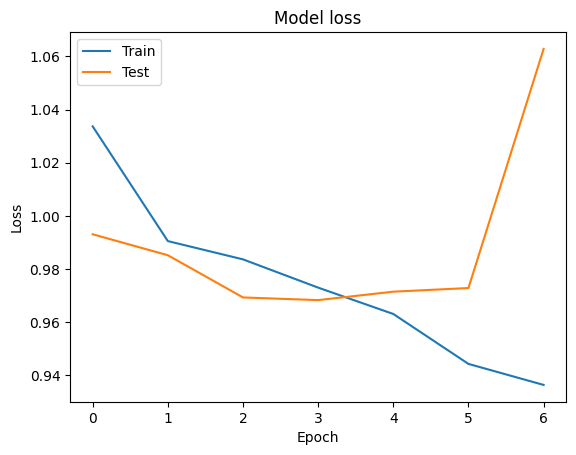

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

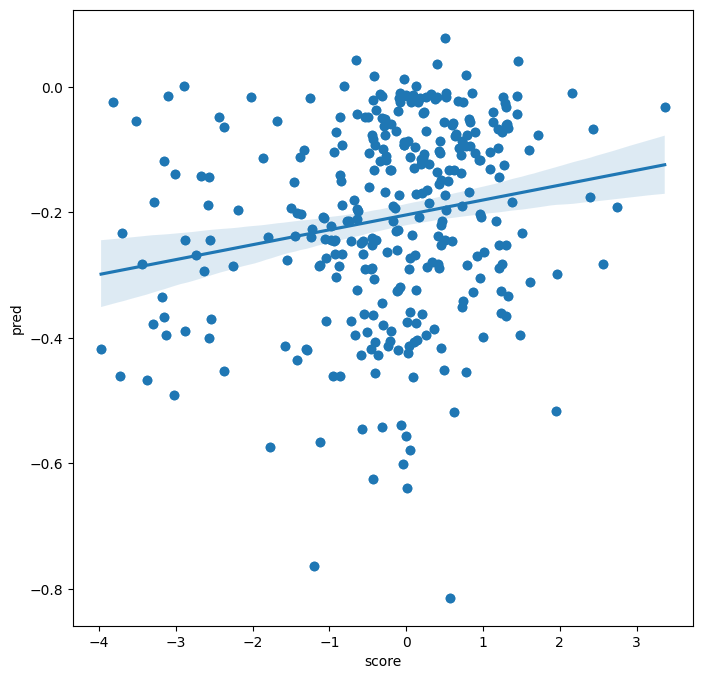

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn import linear_model
# model = linear_model.LinearRegression()
# model.fit(e_test["score"].values.reshape(-1, 1), e_test["pred"].values.reshape(-1, 1))
# e_test=pd.read_csv("test.csv")
sdf = e_test
plt.figure(figsize=(8, 8))
plt.scatter(e_test["score"], e_test["pred"], marker='o')
sns.regplot(x=e_test["score"],  y=e_test["pred"])
plt.xlabel("score")
plt.ylabel("pred")
plt.show()

In [11]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(e_test["score"].values.reshape(-1, 1), e_test["pred"].values.reshape(-1, 1))

In [18]:
e_test["bias"]=e_test.apply(lambda x:abs(x["score"]-x["pred"]),axis=1)
e_test.sort_values(["bias"],ascending=False)[:20]

In [31]:
e_test.sort_values(["abs_score"],ascending=False)[:20]

,Unnamed: 0,seq,rna_counts,plasmid_counts,abs_score,score,length,ttype,scaled_rl
43,43,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCAAA...,17732,17,83.728235,4.427576,118,True,1.624690
73,73,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGAACCAA...,22399,26,69.154177,4.236338,118,True,1.568994
57,57,ATACCGGGTGAAGCACCCGACCATCCTCAGTCACAGAGAGACCCAA...,11655,15,62.371208,4.133104,118,True,1.538929
103,103,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,9554,16,47.932313,3.869790,118,True,1.462242
88,88,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,14334,25,46.024653,3.829177,118,True,1.450414
70,70,ATCCCGGGTGAGGCATCCCAGCATCCTCAGTCACAGAAAGACCCAA...,10736,24,35.908263,3.580967,118,True,1.378126
59,59,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,9355,25,30.037717,3.402454,118,True,1.326136
90,90,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGATCCAA...,5399,15,28.892505,3.363582,118,True,1.314815
68,68,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,12363,41,24.204892,3.186555,118,True,1.263258
64,64,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAG...,9138,31,23.662062,3.163873,118,True,1.256652
